In [202]:
#Importamos algunas cosas

import numpy as np
import matplotlib.pyplot as plt

from qiskit.providers.ibmq import least_busy
import qiskit
from qiskit.visualization import plot_histogram
from qiskit_experiments import library


# Needed for functions
import time

import qiskit.quantum_info as qi
from qiskit.providers.aer import noise
from qiskit.compiler import assemble

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.circuit.library import XGate, YGate, ZGate, U1Gate

from qiskit.quantum_info import Choi, Kraus
from qiskit.extensions import HGate, XGate
import qiskit.quantum_info.operators.channel.transformations as qtrans
import itertools
import csv
#import qiskit.aqua.utils as utils
from qiskit.tools.monitor import job_monitor

from qiskit import QuantumCircuit, QuantumRegister,execute, Aer


from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeLima
#Definimos las matrices de Pauli
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

### Crear una lista de lambdas
Crear una lista de lambdas que se van a simular


In [203]:
def crear_puntos(cantidad):
    '''Crear puntos en el tetraedro'''
    conjunto=[]

    #Creamos los puntos de lambdas 1, 2 y 3.
    l1s = np.linspace(-1,1,cantidad)
    l2s = np.linspace(-1,1,cantidad)
    l3s = np.linspace(-1,1,cantidad)

    #Vamos iterando sobre cada punto
    for elem in itertools.product(l1s,l2s,l3s):
        #Checamos si el punto pertenece al tetrahedro (sino, continuamos)
        if 1+elem[0]-elem[1]-elem[2]<0:
            continue
        if 1+elem[1]-elem[2]-elem[0]<0:
            continue
        if 1+elem[2]-elem[1]-elem[0]<0:
            continue
        if 1+elem[0]+elem[1]+elem[2]<0:
            continue
            
        else:
            #si pertenece, lo agregamos al conjunto de puntos
            conjunto.append(elem)
    return(conjunto)

lista =crear_puntos(9)
len(lista)

249

In [328]:

def crear_puntos(cantidad,tz):
    '''Crear puntos en un corte del tetraedro'''
    conjunto=[]

    #Creamos los puntos de lambdas 1, 2 y 3.
    l1s = np.linspace(-1,1,cantidad)
    l2s = np.linspace(-1,1,cantidad)
    l3s = tz

    #Vamos iterando sobre cada punto
    for elem in itertools.product(l1s,l2s):
        elem = [elem[0],elem[1],tz]

        if np.around(1+elem[0]-elem[1]-elem[2],8)<0:
            continue
        
        elif np.around(1+elem[1]-elem[2]-elem[0],8)<0:
            continue
        elif np.around(1+elem[2]-elem[1]-elem[0],8)<0:
            continue
            
        elif np.around(1+elem[0]+elem[1]+elem[2],8)<0:
            continue   
        else:
            conjunto.append(elem)

    return(conjunto)


lista =crear_puntos(22,-0.5)
print(len(lista))

170


### Funciones para crear los circuitos

In [285]:
def alphas_a_circ(alphas):
    '''Dadas las alphas (que en el artículo se llaman k) crear
    el circuito del canal de Pauli correspondiente.'''
    al0,al1,al2,al3 = alphas
    #Calculamos los ángulos para crear el estado correspondiente sobre ancilla
    th0 = np.angle(np.sqrt(al0)+1j*np.sqrt(al1)) - np.angle(np.sqrt(al2)+1j*np.sqrt(al3))
    th1 = 2*np.arccos(np.sqrt(al0+al1))
    th2 = np.angle(np.sqrt(al0)+1j*np.sqrt(al1)) + np.angle(np.sqrt(al2)+1j*np.sqrt(al3))
    
    # Hacemos el circuito.
    qreg_q = QuantumRegister(3, 'q')  #3 registros cuánticos
    circ = QuantumCircuit(qreg_q)
    
    #Le ponemos las puertas para crear el estado de qbits de ancilla
    circ.ry(th1,1)
    circ.ry(th0,2)
    circ.cz(1,2)
    circ.ry(th2,2)
    
    #Agregamos las puertas controladas sobre el qubit principal
    c2y = YGate.control(YGate(),num_ctrl_qubits=2,ctrl_state='01')
    c2x = XGate.control(XGate(),num_ctrl_qubits=2,ctrl_state='10')
    c2z = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    circ.append(c2x, [1, 2, 0])
    circ.append(c2y, [1, 2, 0])
    circ.append(c2z, [1, 2, 0])

    return(circ)


def lambdas_a_alphas(lambdas):
    '''Convertir las lambdas del tetraedro a las alphas'''
    l1,l2,l3 = lambdas
    al1 =  abs(1/4*(1+l1-l2-l3))
    al2 = abs(1/4*(1-l1+l2-l3))
    al3 = abs(1/4*(1-l1-l2+l3))
    al0= abs(1-al1-al2-al3)
    return(np.around([al0,al1,al2,al3],8))
    

def lambdas_a_circ(lambdas):
    '''Crear un circuito a partir de las lambdas'''
    return(alphas_a_circ(lambdas_a_alphas(lambdas)))


def tomar_elemento(dic,key):
    #Función para tomar un elemento de un diccionario sin obtener error
    # si la key que se busca no existe, sino que da como resultado 0.
    if key in dic:
        return(dic[key])
    else:
        return(0)

In [286]:
def crear_circs(lista):
    '''Crear circuitos correspondientes a puntos en el tetraedro'''
    #Creamos la cuadricula
    
    
    
    circuitos = []
    # Creamos los 12 circuitos de tomografia para cada punto y los ponemos
    #todos en una lista.
    for i in range(len(lista)):
        lambdas = lista[i]
        circ = lambdas_a_circ(lambdas)
        
        circ_qpt = library.ProcessTomography(circ, physical_qubits=[0],
                                    measurement_indices=[0])
        for c in circ_qpt.circuits():
            circuitos.append(c)
            
    return(circuitos)



In [329]:
circuitos = crear_circs(lista)
print(len(circuitos))

2040


# Correr los circuitos y guardar los resultados

In [288]:
# Primero iniciamos sesion
from qiskit import IBMQ
# Cargando cuenta de IBM (para realizar esto es necesaria una cuenta de IBM, preferiblemente esta sección se peude cargar desde IBM quantum lab)
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

#Entrar aqui https://quantum-computing.ibm.com/
#con el correo @ciencias para ver los trabajos enviados y demás

ibmqfactory.load_account:WARNING:2023-07-09 12:38:57,776: Credentials are already in use. The existing account in the session will be replaced.


In [289]:
import os

def correr_circs(compu,circuitos,agregar='',header=False,inicio=0):
    #Creamos una carpeta dentro de resultados, si es que no existe
    if agregar == '':
        agregar = str(np.random.randint(1,1000))
    
    directory = "Resultados/"+compu+agregar
    if os.path.exists(directory) == False:
        os.mkdir(directory)
        
    strin = directory+"/Resultados-Binarios"+'.csv'
    if header==False:
        with open(strin,"a") as f:
            f.write("0,1")
            f.flush()

 
    repeticiones = len(circuitos)//100
    resultados = []
#     qcomp=  provider.get_backend(compu)
    qcomp = AerSimulator.from_backend(FakeLima())

    
    for j in range(inicio,repeticiones):
        circs = circuitos[j*100:(j+1)*100]
        job = qiskit.execute(circs,backend=qcomp, shots=20000)

        # Esto es para saber cuantos trabajos van antes en la fila y como va el nuestro
        job_monitor(job)
        
        res = job.result().get_counts()
        print("finalizado")
        #y agregamos los conteos al csv
        with open(strin,"a") as f:
            for res_i in res:
                data = [tomar_elemento(res_i,'0'),tomar_elemento(res_i,'1')]
                f.write("\n"+str(data[0])+"," + str(data[1]))
                f.flush()
                
                resultados.append(res_i)
            
    
    #Hacemos los circuitos que faltan 
    if len(circuitos) != 100*repeticiones:
        circs=circuitos[100*repeticiones:]
        job = qiskit.execute(circs,backend=qcomp, shots=20000)

        # Esto es para saber cuantos trabajos van antes en la fila y como va el nuestro
        job_monitor(job)
        
        res = job.result().get_counts()
        
        with open(strin,"a") as f:
            for res_i in res:
                data = [tomar_elemento(res_i,'0'),tomar_elemento(res_i,'1')]
                f.write("\n"+str(data[0])+"," + str(data[1]))
                
                resultados.append(res_i)
                f.flush()
    return(resultados)        


In [331]:
correr_circs("ibmq_lima",circuitos,agregar="z=-0.5",header=False,inicio=0);

Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run
finalizado
Job Status: job has successfully run


#### Calcular probabilidades



In [291]:
def choi_objetivo(lambdas):
    '''Para valores de las lambdas, regresa la matriz de Choi objetivo'''
    
    #Primero calculamos las alphas correspondientes
    al0,al1,al2,al3 = lambdas_a_alphas(lambdas)
    
    #Escribimos la representación de Kraus a partir de las alphas 
    k = Kraus([np.sqrt(al0)*I,np.sqrt(al1)*X,
                               np.sqrt(al2)*Y,np.sqrt(al3)*Z])
    
    #Ahora lo convertimos a choi usando _kraus_to_choi
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(qi.Choi(mat_choi))
choi_objetivo([0.4,0.5,0.3])

Choi([[ 0.65+0.j,  0.  +0.j,  0.  +0.j,  0.45+0.j],
      [ 0.  +0.j,  0.35+0.j, -0.05+0.j,  0.  +0.j],
      [ 0.  +0.j, -0.05+0.j,  0.35+0.j,  0.  +0.j],
      [ 0.45+0.j,  0.  +0.j,  0.  +0.j,  0.65+0.j]],
     input_dims=(2,), output_dims=(2,))

### BORRARRRR

In [213]:
lambdas = [0.6,-0.25,-0.5]
print(lambdas_a_alphas(lambdas))
alphas= lambdas_a_alphas(lambdas)

c = alphas_a_circ(alphas)
c.draw()

[0.2125 0.5875 0.1625 0.0375]


┌───┐┌───┐   
q_0: ───────────────────────────────┤ X ├┤ Y ├─■─
     ┌────────────┐                 └─┬─┘└─┬─┘ │ 
q_1: ┤ Ry(0.9273) ├─■─────────────────o────■───■─
     ├────────────┤ │ ┌────────────┐  │    │   │ 
q_2: ┤ Ry(0.5815) ├─■─┤ Ry(1.4772) ├──■────o───■─
     └────────────┘   └────────────┘

In [161]:
ch = choi_objetivo(lambdas)
ch

Choi([[0.25 +0.j, 0.   +0.j, 0.   +0.j, 0.175+0.j],
      [0.   +0.j, 0.75 +0.j, 0.425+0.j, 0.   +0.j],
      [0.   +0.j, 0.425+0.j, 0.75 +0.j, 0.   +0.j],
      [0.175+0.j, 0.   +0.j, 0.   +0.j, 0.25 +0.j]],
     input_dims=(2,), output_dims=(2,))

In [162]:
qcomp = Aer.get_backend('aer_simulator')
circ_qst = library.ProcessTomography(c, physical_qubits=[0],
                                    measurement_indices=[0])

circs= circ_qst.circuits()
circs[1].draw()

┌─────────────┐      ░       ┌───┐┌───┐    ░ »
     q_0: ─────|0>──────┤ PauliPrepZp ├──────░───────┤ X ├┤ Y ├─■──░─»
          ┌────────────┐└─────────────┘      ░       └─┬─┘└─┬─┘ │  ░ »
     q_1: ┤ Ry(0.9273) ├───────■───────────────────────o────■───■────»
          ├────────────┤       │       ┌────────────┐  │    │   │    »
     q_2: ┤ Ry(0.5815) ├───────■───────┤ Ry(1.4772) ├──■────o───■────»
          └────────────┘               └────────────┘                »
c_tomo: 1/═══════════════════════════════════════════════════════════»
                                                                     »
«          ┌────────────┐ ░ ┌─┐
«     q_0: ┤ PauliMeasX ├─░─┤M├
«          └────────────┘ ░ └╥┘
«     q_1: ──────────────────╫─
«                            ║ 
«     q_2: ──────────────────╫─
«                            ║ 
«c_tomo: 1/══════════════════╩═
«                            0

In [163]:
job = qiskit.execute(circs,backend=qcomp, shots=20000)
# Esto es para saber cuantos trabajos van antes en la fila y como va el nuestro
job_monitor(job)        
res = job.result().get_counts()
res                     

Job Status: job has successfully run


[{'1': 15036, '0': 4964},
 {'0': 9958, '1': 10042},
 {'1': 10040, '0': 9960},
 {'0': 15103, '1': 4897},
 {'0': 9982, '1': 10018},
 {'1': 9875, '0': 10125},
 {'0': 10054, '1': 9946},
 {'0': 16006, '1': 3994},
 {'0': 9971, '1': 10029},
 {'1': 9933, '0': 10067},
 {'1': 9951, '0': 10049},
 {'0': 7476, '1': 12524}]

In [172]:
def rho_final(z1,z0,x1,x0,y1,y0):
    #Dados los resultados de un circuito medido en las 3 bases,
    #Calculamos la matriz de densidad del estado final creado
    total = x1+x0
    trax = (x0/total) - (x1/total)
    tray = (y0/total) - (y1/total)
    traz = (z0/total) - (z1/total)
    rho = (I+trax*X+tray*Y+traz*Z)/2

    
    return(np.array(rho))

def choi_desde_res(res):
    # Obtenemos la matriz de densidad final para los 4 estados de entrada
    #El estado 0, el estado 1, el + y el R. 
    #Los se obtienen en los 12 conteos de los circuitos qpt.
    erho0 = rho_final(tomar_elemento(res[0],'1'),tomar_elemento(res[0],'0'),
                      tomar_elemento(res[1],'1'),tomar_elemento(res[1],'0'),
                    tomar_elemento(res[2],'1'),tomar_elemento(res[2],'0'))
    
    erho1 = rho_final(tomar_elemento(res[3],'1'),tomar_elemento(res[3],'0'),
                      tomar_elemento(res[4],'1'),tomar_elemento(res[4],'0'),
                    tomar_elemento(res[5],'1'),tomar_elemento(res[5],'0'))
    
    erhomas = rho_final(tomar_elemento(res[6],'1'),tomar_elemento(res[6],'0'),
                      tomar_elemento(res[7],'1'),tomar_elemento(res[7],'0'),
                    tomar_elemento(res[8],'1'),tomar_elemento(res[8],'0'))
    
    erhoR = rho_final(tomar_elemento(res[9],'1'),tomar_elemento(res[9],'0'),
                      tomar_elemento(res[10],'1'),tomar_elemento(res[10],'0'),
                    tomar_elemento(res[11],'1'),tomar_elemento(res[11],'0'))
    
    

    #A partir de esto, calculamos la matriz de Choi
    #sumando |i><j| \otimes eps(|i><j|)
    #Los eps(|i><j|) se pueden escribir como combinación lineal de los
    # calculados en erho0, erho1, erhomas, erhoR,
    
    choi = np.kron(np.array([[1,0],[0,0]]),erho0)
    choi+= np.kron(np.array([[0,1],[0,0]]),
    erhomas+1j*erhoR-(1+1j)/2*erho0-(1+1j)/2*erho1)
    
    choi+= np.kron(np.array([[0,0],[1,0]]),
            erhomas-1j*erhoR-(1-1j)/2*erho1-(1-1j)/2*erho0)
    
    choi+= np.kron(np.array([[0,0],[0,1]]),erho1)
    return(qi.Choi(choi))

chf = choi_desde_res(res)

np.around(chf,3)

array([[ 0.248+0.j   , -0.002+0.002j,  0.001+0.002j,  0.173+0.008j],
       [-0.002-0.002j,  0.752+0.j   ,  0.43 +0.j   , -0.001-0.002j],
       [ 0.001-0.002j,  0.43 -0.j   ,  0.755+0.j   , -0.001-0.006j],
       [ 0.173-0.008j, -0.001+0.002j, -0.001+0.006j,  0.245+0.j   ]])

In [173]:
ch

Choi([[0.25 +0.j, 0.   +0.j, 0.   +0.j, 0.175+0.j],
      [0.   +0.j, 0.75 +0.j, 0.425+0.j, 0.   +0.j],
      [0.   +0.j, 0.425+0.j, 0.75 +0.j, 0.   +0.j],
      [0.175+0.j, 0.   +0.j, 0.   +0.j, 0.25 +0.j]],
     input_dims=(2,), output_dims=(2,))

##### Choi desde resultados

In [292]:
def rho_final(z1,z0,x1,x0,y1,y0):
    #Dados los resultados de un circuito medido en las 3 bases,
    #Calculamos la matriz de densidad del estado final creado
    total = x1+x0
    trax = (x0/total) - (x1/total)
    tray = (y0/total) - (y1/total)
    traz = (z0/total) - (z1/total)
    rho = (I+trax*X+tray*Y+traz*Z)/2
    
    return(np.array(rho))



def tomar_elemento(dic,key):
    #Función para tomar un elemento de un diccionario sin obtener error
    # si la key que se busca no existe, sino que da como resultado 0.
    if key in dic:
        return(dic[key])
    else:
        return(0)
    
    
def choi_desde_res(res):
    # Obtenemos la matriz de densidad final para los 4 estados de entrada
    #El estado 0, el estado 1, el + y el R. 
    #Los se obtienen en los 12 conteos de los circuitos qpt.
    erho0 = rho_final(tomar_elemento(res[0],'1'),tomar_elemento(res[0],'0'),
                      tomar_elemento(res[1],'1'),tomar_elemento(res[1],'0'),
                    tomar_elemento(res[2],'1'),tomar_elemento(res[2],'0'))
    
    erho1 = rho_final(tomar_elemento(res[3],'1'),tomar_elemento(res[3],'0'),
                      tomar_elemento(res[4],'1'),tomar_elemento(res[4],'0'),
                    tomar_elemento(res[5],'1'),tomar_elemento(res[5],'0'))
    
    erhomas = rho_final(tomar_elemento(res[6],'1'),tomar_elemento(res[6],'0'),
                      tomar_elemento(res[7],'1'),tomar_elemento(res[7],'0'),
                    tomar_elemento(res[8],'1'),tomar_elemento(res[8],'0'))
    
    erhoR = rho_final(tomar_elemento(res[9],'1'),tomar_elemento(res[9],'0'),
                      tomar_elemento(res[10],'1'),tomar_elemento(res[10],'0'),
                    tomar_elemento(res[11],'1'),tomar_elemento(res[11],'0'))
    
    

    #A partir de esto, calculamos la matriz de Choi
    #sumando |i><j| \otimes eps(|i><j|)
    #Los eps(|i><j|) se pueden escribir como combinación lineal de los
    # calculados en erho0, erho1, erhomas, erhoR,
    
    choi = np.kron(np.array([[1,0],[0,0]]),erho0)
    choi+= np.kron(np.array([[0,1],[0,0]]),
    erhomas+1j*erhoR-(1+1j)/2*erho0-(1+1j)/2*erho1)
    
    choi+= np.kron(np.array([[0,0],[1,0]]),
            erhomas-1j*erhoR-(1-1j)/2*erho1-(1-1j)/2*erho0)
    
    choi+= np.kron(np.array([[0,0],[0,1]]),erho1)
    return(qi.Choi(choi))


In [293]:
import pandas as pd

def crear_dict(df):
    d = []
    lista = np.array(df)
    for a in lista:
        d.append({'0': a[0], '1': a[1]})
    return(d)


def fidelidades(direction,lista):
    resultados_bin = pd.read_csv(direction + "/Resultados-Binarios.csv")
    strin = direction+"/fidelidades.csv"
    
    with open(strin,"w") as f:
        f.write("lambda1, lambda2, lambda3, fidelidad")
    
    for i, lam in enumerate(lista):
        resul_i = resultados_bin.iloc[12*i:12*i+12]
        d = crear_dict(resul_i)
        
        choi_obj = choi_objetivo(lam)
        choi_compu = choi_desde_res(d)
        
        fid =qi.process_fidelity(qi.Choi(choi_compu),target=choi_obj)
        
        
        data = (lam[0],lam[1],lam[2],fid)
        
        with open(strin,"a") as f:
            f.write("\n"+str(data[0])+"," + str(data[1])+","+str(data[2])+","+str(data[3]))

            
            
def fidelidades_proba(direction,lista):
    resultados_bin = pd.read_csv(direction + "/Resultados-Binarios.csv")
    strin = direction+"/fidelidades_diam1.csv"
    
    with open(strin,"w") as f:
        f.write("lambda1, lambda2, lambda3, fidelidad")
    
    for i, lam in enumerate(lista):
        resul_i = resultados_bin.iloc[12*i:12*i+12]
        d = crear_dict(resul_i)
        
        choi_obj = choi_objetivo(lam)
        choi_compu = choi_desde_res(d)
        
        fid =qi.diamond_norm(qi.Choi(choi_compu)-choi_obj)
        
        proba= 1/2+1/4*fid
        data = (lam[0],lam[1],lam[2],proba)
        
        with open(strin,"a") as f:
            f.write("\n"+str(data[0])+"," + str(data[1])+","+str(data[2])+","+str(data[3]))


            
def fidelidades_diam(direction,lista):
    resultados_bin = pd.read_csv(direction + "/Resultados-Binarios.csv")
    strin = direction+"/fidelidades_diam1.csv"
    
    with open(strin,"w") as f:
        f.write("lambda1, lambda2, lambda3, fidelidad")
    
    for i, lam in enumerate(lista):
        resul_i = resultados_bin.iloc[12*i:12*i+12]
        d = crear_dict(resul_i)
        
        choi_obj = choi_objetivo(lam)
        choi_compu = choi_desde_res(d)
        
        fid =qi.diamond_norm(qi.Choi(choi_compu)-choi_obj)
        
        data = (lam[0],lam[1],lam[2],1-0.5*fid)
        
        with open(strin,"a") as f:
            f.write("\n"+str(data[0])+"," + str(data[1])+","+str(data[2])+","+str(data[3]))

   


In [332]:
lista =crear_puntos(22,-0.5)
print(len(lista))

170


In [333]:
fidelidades_diam("Resultados/ibmq_limaz=-0.5",lista)


## Dibujar

C:\Users\tbasi\AppData\Local\Temp\ipykernel_10540\2037186507.py:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(colmap)


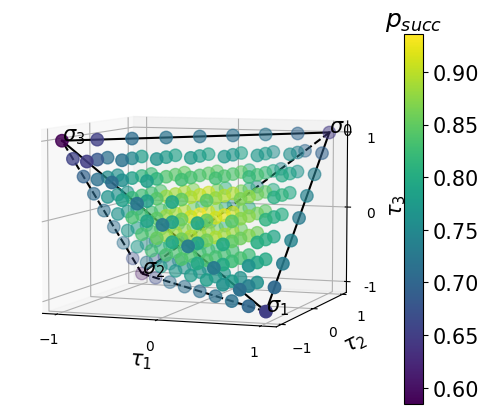

In [334]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import csv
from matplotlib import cm
def graficar(documento): 
    file = open(documento)
    csvreader = csv.reader(file)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
        
    ax.plot([1,1],[1,-1],[1,-1],'k')
    ax.plot([1,-1],[1,1],[1,-1],'k--')
    ax.plot([1,-1],[1,-1],[1,1],'k')
    ax.plot([-1,1],[1,-1],[-1,-1],'k--')
    ax.plot([-1,-1],[1,-1],[-1,1],'k--')
    ax.plot([1,-1],[-1,-1],[-1,1],'k')
    #     plt.plot(0,0,0,'ko')

    ax.text(1,1,1,'$\sigma_0$',size=15)
    ax.text(1,-1,-1,'$\sigma_1$',size=15)
    ax.text(-1,1,-1,'$\sigma_2$',size=15)
    ax.text(-1,-1,1,'$\sigma_3$',size=15)
#     ax.text(0,0,0,'O',size=20)

    ax.set_xlabel(r'$\tau_1$', fontsize=15)
    ax.set_ylabel(r'$\tau_2$',fontsize=15)

    plt.xticks([-1,0,1],fontsize=10)
    plt.yticks([-1,0,1],fontsize=10)
    ax.set_zticks([-1, 0, 1])
    ax.set_zticklabels([-1,0,1],fontsize=10)
    ax.set_zlabel(r'$\tau_3$', fontsize=15, rotation = 0)


    xs = []
    ys = []
    zs = []
    four= []
    for row in csvreader:
        if row[0] == 'lambda1':
            continue
        xs.append(float(row[0]))
        ys.append(float(row[1]))
        zs.append(float(row[2]))
        four.append(float(row[3]))
        
    colors = cm.viridis((np.array(four)-min(four))/(max(four)-min(four)))
    colmap = cm.ScalarMappable(cmap=cm.viridis)
    colmap.set_array(four)
    
    
    yg = ax.scatter(xs, ys, zs, c=colors, marker='o',s=80)
    cb = fig.colorbar(colmap)
    cb.ax.tick_params(labelsize=15) 
    
    cb.ax.set_title("$p_{succ}$",fontsize=18)
    ax.view_init(6,290)

    plt.show()

graficar('Resultados/ibmq_limatetra9/fidelidades_diam1.csv')

[0.0]


C:\Users\tbasi\AppData\Local\Temp\ipykernel_10540\249073413.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(colmap)


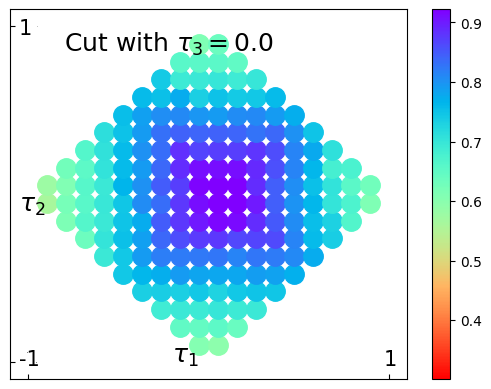

In [339]:
%matplotlib inline

from matplotlib import cm

file = open('Resultados/ibmq_limaz=0/fidelidades_diam1.csv')
csvreader = csv.reader(file)
xs = []
ys = []
zs = []
trio=[]
color = []
for row in csvreader:
    if row[0] == 'lambda1':
        continue
    xs.append(float(row[0]))
    ys.append(float(row[1]))
    zs.append(float(row[2]))
    trio.append([float(row[0]),float(row[1]),float(row[2]),
#                  (((1-float(row[3]))*2*1)*1.25-0.301)/0.621])
#                  cm.rainbow_r( (((1-float(row[3]))*2*1)*1.25-0.301)/0.621)   ])
                 cm.rainbow_r((float(row[3])-0.5846)/(0.9356-0.5846))])

setz = sorted(set(zs))
print(setz)
i=1

for z in setz:
    fig,ax = plt.subplots()

    for obj in trio:
        if z == obj[2]:
            plt.plot(obj[0],obj[1],marker='o',c=obj[3],markersize=14)
            
    plt.xticks([-1,1],fontsize=1)
    ax.tick_params(axis="x",direction="in",pad=-20)
    plt.yticks([-1,1],fontsize=1)
    ax.tick_params(axis="y",direction="in",pad=-20)
    
    plt.text(-0.2,-1,r'$\tau_1$',fontsize=18)
    plt.text(-1.05,-0.1,r'$\tau_2$',fontsize=18)
    plt.text(-1.05,0.95,"1",fontsize=15)
    plt.text(-1.05,-1.02,"-1",fontsize=15)
    plt.text(0.97,-1.02,"1",fontsize=15)
    
#     plt.xlabel(r"$\tau_1$",fontsize=20)
#     plt.ylabel(r"$\tau_2$",fontsize=20)

    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    
    plt.text(-0.8,0.85,r'Cut with $\tau_3 = $' + str(np.around(z,3)),fontsize=18)
#     plt.title(r'Cut with $\tau_3 = $' + str(np.around(z,3)),fontsize=18)
    
    colmap = cm.ScalarMappable(cmap=cm.rainbow_r)
    colmap.set_array([0.301,0.922])
    
    cb = fig.colorbar(colmap)
#     cb.ax.tick_params(labelsize=10) 
    
#     cb.ax.set_title("$f$",fontsize=18)
    
#     plt.savefig('imagenes-tetra/'+'Corte ' + 'z cte'+str(i)+'.png')
    plt.show()
    i+=1


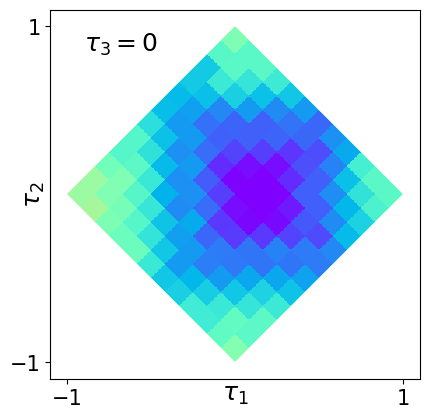

In [345]:
import matplotlib.transforms as mtransforms


from matplotlib import cm

file = open('Resultados/ibmq_limaz=0/fidelidades_diam1.csv')
csvreader = csv.reader(file)
xs = []
ys = []
zs = []
trio=[]
color = []
for row in csvreader:
    if row[0] == 'lambda1':
        continue
    xs.append(float(row[0]))
    ys.append(float(row[1]))
    zs.append(float(row[2]))
    trio.append([float(row[0]),float(row[1]),float(row[2]),
                 (float(row[3])-0.5846)/(0.9356-0.5846)])
                 
                 

def do_plot(ax, Z, transform):
    im = ax.imshow(Z, interpolation='none',
                   origin='lower',
                   extent=[0, 1, 0, 1], clip_on=True,
                   cmap =cm.rainbow_r,
                  vmin=0,
                  vmax=1)

    trans_data = transform + ax.transData
    im.set_transform(trans_data)

    # display intended extent of the image
    x1, x2, y1, y2 = im.get_extent()
#     ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1],
#             transform=trans_data)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    
tz = 0
    
def transformacion(x,y,tz):
    res1 = x*(1-tz) + y * (1+tz) - 1
    res2 = x*(tz-1) + y*(1+tz) - tz
    
    return(res1,res2)
    
    
ny = 12
nx = 12


def mas_cercano(px,py):
    mini = 1000
    for  i in range(len(xs)):
        punto = [xs[i],ys[i]]
        distancia = (px-xs[i])**2 + (py-ys[i])**2   
        
        if distancia < mini:
            mini = distancia
            mejor_i = i
    return(trio[mejor_i][-1])
        
mat = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        px,py = transformacion(i/nx, j/ny,tz)
        
        mat[i][j] = mas_cercano(px,py)
        

        
fig, ax = plt.subplots(1,1)

do_plot(ax, mat, mtransforms.Affine2D().scale(np.sqrt(2)*(tz+1),np.sqrt(2)*(tz-1)).rotate_deg(45).translate(-1,-tz))

plt.xticks([-1,1],fontsize=15)
# ax.tick_params(axis="x",direction="in",pad=-2)
plt.yticks([-1,1],fontsize=15)
# ax.tick_params(axis="y",direction="in",pad=-20)
    
# plt.text(-0.2,-1,r'$\tau_1$',fontsize=18)
# plt.text(-1.05,-0.15,r'$\tau_2$',fontsize=18)
# plt.text(-1.05,0.95,"1",fontsize=15)
# plt.text(-1.05,-1.02,"-1",fontsize=15)
# plt.text(0.97,-1.02,"1",fontsize=15)
    
plt.xlabel(r"$\tau_1$",fontsize=18)
plt.ylabel(r"$\tau_2$",fontsize=18)
ax.xaxis.set_label_coords(0.5, -.01)
ax.yaxis.set_label_coords(-0.01, 0.5)


plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
    
plt.text(-0.9,0.85,r'$\tau_3 = 0$' 
# plt.text(0.3,0.85,r'$\tau_3 =-0.5$' 

         #+ str(np.around(tz,3)),
         ,fontsize=18)

plt.show()


In [103]:
# 0.5  15,8
# -0.5 8,15    0.95
# 0 12,12      0.97
# -1  8,50    0.93
# 1 50,8
 

-0.04376979079977427

In [42]:
xs

[-0.9047619047619048,
 -0.9047619047619048,
 -0.8095238095238095,
 -0.8095238095238095,
 -0.8095238095238095,
 -0.8095238095238095,
 -0.7142857142857143,
 -0.7142857142857143,
 -0.7142857142857143,
 -0.7142857142857143,
 -0.7142857142857143,
 -0.7142857142857143,
 -0.6190476190476191,
 -0.6190476190476191,
 -0.6190476190476191,
 -0.6190476190476191,
 -0.6190476190476191,
 -0.6190476190476191,
 -0.6190476190476191,
 -0.6190476190476191,
 -0.5238095238095238,
 -0.5238095238095238,
 -0.5238095238095238,
 -0.5238095238095238,
 -0.5238095238095238,
 -0.5238095238095238,
 -0.5238095238095238,
 -0.5238095238095238,
 -0.5238095238095238,
 -0.5238095238095238,
 -0.4285714285714286,
 -0.4285714285714286,
 -0.4285714285714286,
 -0.4285714285714286,
 -0.4285714285714286,
 -0.4285714285714286,
 -0.4285714285714286,
 -0.4285714285714286,
 -0.4285714285714286,
 -0.4285714285714286,
 -0.4285714285714286,
 -0.33333333333333337,
 -0.33333333333333337,
 -0.33333333333333337,
 -0.33333333333333337,
 -0.33

[1.0]


C:\Users\tbasi\AppData\Local\Temp\ipykernel_12792\4009705603.py:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(colmap)


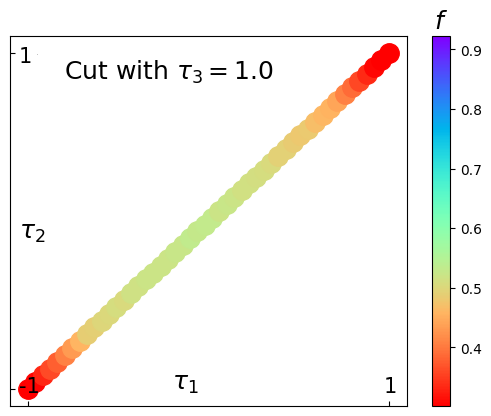

In [73]:
%matplotlib inline

from matplotlib import cm

file = open('Resultados/ibmq_limaz=1/fidelidades_diam1.csv')
csvreader = csv.reader(file)
xs = []
ys = []
zs = []
trio=[]
color = []
for row in csvreader:
    if row[0] == 'lambda1':
        continue
    xs.append(float(row[0]))
    ys.append(float(row[1]))
    zs.append(float(row[2]))
    trio.append([float(row[0]),float(row[1]),float(row[2]),
                 cm.rainbow_r( (((1-float(row[3]))*2*1)*1.25-0.301)/0.621)   ])


setz = sorted(set(zs))
print(setz)
i=1

for z in setz:
    fig,ax = plt.subplots()

    for obj in trio:
        if z == obj[2]:
            plt.plot(obj[0],obj[1],marker='o',c=obj[3],markersize=14)
            
    plt.xticks([-1,1],fontsize=1)
    ax.tick_params(axis="x",direction="in",pad=-20)
    plt.yticks([-1,1],fontsize=1)
    ax.tick_params(axis="y",direction="in",pad=-20)
    
    plt.text(-0.2,-1,r'$\tau_1$',fontsize=18)
    plt.text(-1.05,-0.1,r'$\tau_2$',fontsize=18)
    plt.text(-1.05,0.95,"1",fontsize=15)
    plt.text(-1.05,-1.02,"-1",fontsize=15)
    plt.text(0.97,-1.02,"1",fontsize=15)
    
#     plt.xlabel(r"$\tau_1$",fontsize=20)
#     plt.ylabel(r"$\tau_2$",fontsize=20)

    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    
    plt.text(-0.8,0.85,r'Cut with $\tau_3 = $' + str(np.around(z,3)),fontsize=18)
#     plt.title(r'Cut with $\tau_3 = $' + str(np.around(z,3)),fontsize=18)
    
    colmap = cm.ScalarMappable(cmap=cm.rainbow_r)
    colmap.set_array([0.301,0.922])
    
    cb = fig.colorbar(colmap)
    cb.ax.tick_params(labelsize=10) 
    
    cb.ax.set_title("$f$",fontsize=18)
    
#     plt.savefig('imagenes-tetra/'+'Corte ' + 'z cte'+str(i)+'.png')
    plt.show()
    i+=1
